# **Menjadi Powerful dengan Tensorflow - Hands On**
> ## Aditya Firman Ihsan
[![Github](https://img.shields.io/badge/Visit-My%20Github-black.svg)](https://github.com/phoenixfin) [![contact](https://img.shields.io/badge/Email-Contact-crimson.svg)](mailto:adityaihsan@telkomuniversity.ac.id)

---

[![contact](https://img.shields.io/badge/TensorFlow%20-%23FF6F00.svg?&style=for-the-badge&logo=TensorFlow&logoColor=white)](https://www.tensorflow.org/)
[![Generic badge](https://img.shields.io/badge/Data%20Science-Telkom%20University-red.svg)](https://telkomuniversity.ac.id/)
[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/187F05TJCOX76_THbLGi3UzOIuUJU3p5Q?usp=sharing)

<img src="https://pngimage.net/wp-content/uploads/2018/06/logo-tel-u-png-6.png" alt="drawing" height="100"/><img src="https://miro.medium.com/max/4928/1*-QTg-_71YF0SVshMEaKZ_g.png" alt="drawing" height="100"/>


# **﷽**

Dalam notebook ini, akan dipaparkan secara general dari A-Z apa yang bisa dilakukan dengan Tensorflow, beserta beberapa teknik yang ada di dalamnya. Tentu banyak yang tidak tercakup di sini, sehingga bila tertarik untuk belajar lebih dalam terkait Tensorflow bisa langsung ke [dokumentasinya](tensorflow.org) 


## 0. Prepare

### 0.1. Import Libraries

Mula-mula di impor terlebih dahulu semua *libary* yang dibutuhkan

In [ ]:
import PIL # untuk mengolah gambar
import random # untuk menghasilkan bilangan acak
import datetime # untuk mengambil waktu saat ini
import numpy as np # untuk kebutuhan numerik
import pandas as pd # untuk mengolah data
import matplotlib.pyplot as plt # untuk plotting

import tensorflow as tf # yang utama nih
import tensorflow_hub as hub
import tensorflow_datasets as tfds 

# setup dulu logger dari tf biar tidak terlalu banyak output
tf.get_logger().setLevel('ERROR')

### 0.1. Helper Function

Sebelum mulai, didefinisikan dulu beberapa fungsi bantuan. Tidak perlu paham ini buat apa, nanti ketika ketemu dengan pemanggilannya, baru terlihat.

In [ ]:
# untuk membagi data berdasarkan rasio
def split(x, y, ratio=0.8):
    split_index = round(ratio * len(x))
    slice1 = x[:split_index], y[:split_index]
    slice2 = x[split_index:], y[split_index:]
    return slice1, slice2

# untuk plotting metrik yang dihasilkan dari training
def plot_metrics(history, metrics):
    plt.title("Model Performance")
    for metric in metrics:
        plt.plot(history.history[metric],label=metric)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

# untuk mengonvers gambar agar siap masuk ke model
def prepare_image(img, size, module=None):
    img = tf.expand_dims(img, -1)
    img = tf.repeat(img, 3, -1)
    img = tf.image.resize(img, size)  
    if module:
        img = module.preprocess_input(img)
    return img

# untuk menampilkan banyak gambar
def show_figures(images, preds, pairs=False):
    plt.figure(figsize=(10,5))
    if pairs:
        images, comp_images = images
        for n, img in enumerate(comp_images):
            plt.subplot(3,5,5+n+1)
            plt.axis('off')
            plt.imshow(img)
    for n, img in enumerate(images):
        plt.subplot(3,5,n+1)
        plt.title(f'Prediksi: {preds[n]}')
        plt.axis('off')
        plt.imshow(img)
    plt.suptitle("Model predictions")

### 0.2. Import Data

Ada 3 data berbeda yang akan digunakan sepanjang notebook ini, yakni data numerik, data gambar, dan data teks. Masing-masing data akan dibagi menjadi triadik *training-validation-test* yang menjadi standar penggunaan data dalam suatu model *Machine Learning*. 

![](https://www.machinecurve.com/wp-content/uploads/2020/11/feed-3.jpg)

#### 0.2.1. Data Numerik (Titanic)

In [ ]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_df = pd.read_csv(titanic_file)

# lihat dulu sebagian isinya
titanic_df.head()

In [ ]:
list_town = list(titanic_df['embark_town'].unique())
list_class = list(titanic_df['class'].unique())

# mengubah fitur kategorikal menjadi "one-hot"
titanic_df[list_town] = pd.get_dummies(titanic_df['embark_town'])
titanic_df[list_class] = pd.get_dummies(titanic_df['class'])

features = titanic_df[list_town + list_class + ['age']]
labels = titanic_df['survived']

(x, y), (x_test, y_test) = split(features, labels, 0.9)
(x_train, y_train), (x_val, y_val) = split(x, y)

# lihat lagi hasilnya seperti apa
x_train

#### 0.2.2. Data Gambar (Tulisan tangan angka)

Jumlah Data Training:  48000
Jumlah Data Validasi:  12000
Jumlah Data Test:  10000
Dimensi setiap data (h x w pixels):  (28, 28)

Contoh gambar:


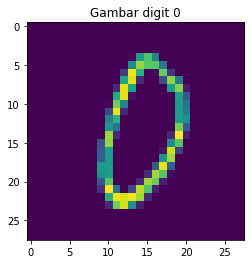

In [123]:
(img_train, lab_train), (img_test, lab_test) = tf.keras.datasets.mnist.load_data()
img_train = img_train / 255.0
img_test = img_test / 255.0

(img_train, lab_train), (img_val, lab_val) = split(img_train, lab_train)

# overview datanya seperti apa
print('Jumlah Data Training: ', len(img_train))
print('Jumlah Data Validasi: ', len(img_val))
print('Jumlah Data Test: ', len(img_test))
print("Dimensi setiap data (h x w pixels): ", img_train[0].shape)

# ambil sampel acak. Coba saja jalankan berkali-kali, hasilnya berbeda
index = random.randint(0,len(img_train))
print("\nContoh gambar:")
plt.title(f'Gambar digit {lab_train[index]}')
plt.imshow(img_train[index])

#### 0.2.3. Data Text (Judul berita)

In [ ]:
text_file = tf.keras.utils.get_file("sarcasm.json", "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json")
data = pd.read_json(text_file)
data.head()

In [ ]:
sentences = data['headline']
classes = data['is_sarcastic']

# membagi data menjadi triad train-val-test
(snt_train, cls_train), (snt_test, cls_test) = split(sentences, classes)
(snt_train, cls_train), (snt_val, cls_val) = split(snt_train, cls_train)

# dicek dulu sebagian hasilnya
for i in range(5):
  lab = "Sarkas!" if cls_train[i] == 1 else "Netral"
  print(f'"{snt_train[i]}" -- {lab}')

Setelah ini, akan dilakukan beberapa proses pembuatan model sederhana dengan berbagai API yang berbeda. Tensorflow kurang lebih memiliki fleksibilitas dalam penggunaannya sperti berikut

![](https://github.com/phoenixfin/deeplearning-notebooks/blob/main/fleksibilitas_tf.png?raw=true)

## 1. High Level API


Dalam High-Level API, kita hanya melihat bungkusnya Tensorflow saja, yang sudah siap pakai dan tinggal disesuaikan dengan kebutuhan

### 1.2. Estimators

![](https://codespeedy.com/wp-content/uploads/2020/06/Schematic-diagram-of-an-estimator.png)

Estimator merupakan model yang sudah dibundel sehingga pengguna hanya cukup menyediakan fungsi input dan data, dan selebihnya semua tinggal jalan.

In [ ]:
# menyiapkan fungsi input. Dalam hal ini, tf.data API digunakan
def train_input_fn():
  titanic = tf.data.experimental.make_csv_dataset(
      titanic_file, batch_size=32,
      label_name="survived")
  titanic_batches = (
      titanic.cache().repeat().shuffle(500)
      .prefetch(tf.data.AUTOTUNE))
  return titanic_batches

# melihat 1 batch data isinya apa
for data in train_input_fn().take(1):
  for key in data[0]:
    print("=>", key)
    print(data[0][key].numpy(),'\n')

In [ ]:
# mendefinisikan fitur-fitur yang akan dilibatkan di model
age = tf.feature_column.numeric_column('age')
cls = tf.feature_column.categorical_column_with_vocabulary_list('class', ['First', 'Second', 'Third']) 
embark = tf.feature_column.categorical_column_with_hash_bucket('embark_town', 32)

# definisikan  modelnya
model = tf.estimator.LinearClassifier(    
    model_dir = './estimator_logs',
    feature_columns=[embark, cls, age],
    n_classes=2
)

In [ ]:
model = model.train(input_fn=train_input_fn, steps=100)
result = model.evaluate(train_input_fn, steps=10)

for key, value in result.items():
  print(key, ":", value)

In [ ]:
for pred in model.predict(train_input_fn):
  for key, value in pred.items():
    print(key, ":", value)
  break

### 1.2. Keras Sequential

![](https://miro.medium.com/max/394/1*CNPWTqFeMeCFkLOWjJU9Vg.jpeg)

Keras Sequential API digunakan untuk membangun model secara sederhana dengan cukup membuat daftar layer yang digunakan. Cara membangun modelnya ada dua:
1. Dengan memasukkan langsung daftar layer sebagai argumen ketika membuat model. Sintaksnya adalah sebagai berikut 
```
model = tf.keras.Sequential(layers_list)
``` 
dengan `layers_list` merupakan daftar layers yang digunakan secara berurutan.

2. Bisa juga dengan menambahkan layer satu per satu belakangan. Jadi kita definisikan dulu modelnya tanpa argumen
```
model = tf.keras.Sequential()
``` 
dan kemudian, kita gunakan metode `add` seperti berikut
```
model.add(layer1)
model.add(layer2)
``` 



#### 1.2.1. Implementasi

##### a. Regresi

Kita mulai dari data yang sederhana dulu. Dalam hal ini, dibangun data linier yang diberi gangguan 

In [ ]:
x = np.arange(10)
y_true = 3.21*x + 1.4
y_noise = y_true + tf.random.uniform((10,), minval=-10., maxval=10.)
plt.plot(x,y_noise, 'o')

Selanjutnya, kita definisikan modelnya, cukup sebuah neural network dengan 1 layer output atau dikenal juga sebagai *Perceptron*

![](https://miro.medium.com/max/645/1*YPguig_eDkgWi5cgvWiUBg.png)

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model.fit(x,y_noise, epochs=10)

y_pred = model.predict(x)
plt.plot(x,y_noise, 'o')
plt.plot(x, y_pred)

Sederhana bukan? Setelah ini kita coba lebih rumit dengan melaukan klasifikasi pada 3 data berbeda yang telah disiapkan sebelumnya

##### b. Klasifikasi (Numerik)

Langsung kita definisikan saja modelnya karena datanya sudah siap. Dalam hal ini, berhubung korelasi datanya belum tentu linier, kita gunakan neural network dengan 2 layer tersembunyi (disebut juga *Multi-Layer Perceptron*) dan fungsi "aktivasi" ReLU untuk memberi dia nonlinearitas

![](https://raw.githubusercontent.com/ledell/sldm4-h2o/master/mlp_network.png)

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("=== Performance on Test Data: ===")
print("Loss:", test_loss)
print("Accuracy:", test_acc, "\n")

plot_metrics(hist, ['accuracy'])

print("\n=== Some Test Samples: ===")
samples = random.sample(list(x_test.index), 5)
preds = model.predict(x_test.loc[samples]) >= 0.5
for i, idx in enumerate(samples):
    print("Truth:", y_test.loc[idx], "| Predicted:", int(preds[i]))

##### c. Klasifikasi (Gambar)

Model yang akan digunakan masih berupa *Multi-Layer Perceptron*. Kali ini layer output diberi aktivasi *softmax* untuk mendapatkan probabilitas dari 10 kelas.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(img_train, lab_train, batch_size=64, epochs=5)

In [ ]:
test_loss, test_acc = model.evaluate(img_test, lab_test)
print("=== Performance on Test Data: ===")
print("Loss:", test_loss)
print("Accuracy:", test_acc, "\n")

plot_metrics(hist, ['accuracy'])

print("\n=== Some Test Samples: ===")
samples = random.sample(img_test.tolist(), 5)
preds = np.argmax(model.predict(samples),axis=1)
show_figures(samples, preds)

Kita juga bisa membuat model berbentuk konvolusional. Arsitektur model yang dikenal juga sebagai CNN (Convolutional Neural Network) ini, menggunakan filter untuk mendapatkan informasi yang lebih dalam dari suatu gambar. Filter ini kemudian menjadi parameter yang dioptimisasi selama training.

Suatu layer konvolusional di CNN biasanya diikuti dengan layer untuk *downsampling* (memperkecil resolusi dari suatu gambar) dengan tujuan untuk memperingan serta untuk mendapatkan informasi yang lebih abstrak pada layer berikutnya. Layer downsampling yang umum digunakan adalah Maximum Pooling, yakni mengambil piksel maksimum dari suatu set piksel, sehingga ukuran mengecil tanpa kehilangan informasi terlalu banyak.

Gambaran arsitektur CNN kurang lebih seperti berikut
![](https://miro.medium.com/proxy/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

Pada gambar di atas, digunakan dua pasang layer konvolusional-pooling sebelum kemudian diratakan ke dense network. Untuk sekarang, kita coba bangun arsitektur yang lebih sederhana dengan cukup 1 pasang konvolusional-pooling.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(img_train, lab_train, batch_size=64, epochs=5)
plot_metrics(hist, ['accuracy'])

Performanya tidak jauh berbeda dengan model dense network biasa. Hal ini dikarenakan memang data yang digunakan relatif kecil dan tidaklah kompleks. CNN akan terasa manfaatnya untuk klasifikasi atau proses training gambar yang lebih rumit.

##### c. Klasifikasi (Text)

Khusus untuk data text, kita perlu kuantifikasi data tersebut agar bisa masuk ke model. Ada dua tahap untuk melakukan ini:
- **Tokenisasi**, artnya mengonversi 1 kalimat utuh menjadi bagian-bagian yang diinginkan (biasanya per kata) dimana setiap bagian itu diwakilkan 1 token.
- ***Embedding***, artinya memroyeksikan setiap token ke suatu vektor (array) n-dimensi agar bisa merepresentasikan posisi kata tersebut dan relasinya dengan kata lainnya.

![](https://freecontent.manning.com/wp-content/uploads/Chollet_DLfT_01.png)


In [ ]:
prep = tf.keras.preprocessing

# definisikan dulu pembuat tokennya
tokenizer = prep.text.Tokenizer(num_words=1000, oov_token='<OOV>')
# agar kemudian bisa disesuaikan dengan data trainng
tokenizer.fit_on_texts(snt_train)

seq_train = tokenizer.texts_to_sequences(snt_train)
seq_val = tokenizer.texts_to_sequences(snt_val)
seq_test = tokenizer.texts_to_sequences(snt_test)

# kita lihat hasil tokennnya seperti apa
seq_train[:5]

In [ ]:
# kita lakukan hal yang sama setiap data (train-val-test)
pad_train = prep.sequence.pad_sequences(seq_train, maxlen=50, padding='post', truncating='post')
pad_val = prep.sequence.pad_sequences(seq_val, maxlen=50, padding='post', truncating='post')
pad_test = prep.sequence.pad_sequences(seq_test, maxlen=50, padding='post', truncating='post')

pad_train[:5]

Model yang akan dipakai adalah model RNN (*Recurrent Neural Network*) dengan cell LSTM (*Long Short-Term Memory*) yang *Bidirectional*. Berhubung di luar bahasan dan tidak sederhana, maka tidak akan dibahas secara detail di sini.

![](https://paperswithcode.com/media/methods/Screen_Shot_2020-05-25_at_8.54.27_PM.png)

In [ ]:
# layer pertama dari model merupakan layer untuk melakukan proses embedding
# dari token yang sudah dibuat. Angka 1000 di sini berarti jumlah token yang digunakan
# dan 16 berarti dimensi vektor hasil embedding yang digunakan
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(pad_train, cls_train, epochs=5, validation_data=(pad_val, cls_val))

In [ ]:
test_loss, test_acc = model.evaluate(pad_test, cls_test)
print("=== Performance on Test Data: ===")
print("Loss:", test_loss)
print("Accuracy:", test_acc, "\n")

plot_metrics(hist, ['accuracy'])

print("\n=== Some Test Samples: ===")
samples_idx = random.sample(range(len(pad_test)), 5)
pad_samples = pad_test[samples_idx]
preds = model.predict(pad_samples) >= 0.5
for i, idx in enumerate(samples_idx):
    pred_lab = "Sarkas!" if preds[i] else "Netral"
    true_lab = "Sarkas!" if cls_test.iloc[idx] else "Netral"
    print(f'[Pred: {pred_lab}; Truth: {true_lab}] "{snt_test.iloc[idx]}"')

#### 1.2.2. Beberapa fitur

##### a. Summary dan Plot

Untuk melihat secara ringkas data arsitektur model yang sudah dibangun, kita bisa gunakan metode `.summary`. Misalkan, untuk model RNN yang sudah dibangun sebelumnya kita punya summary seperti berikut.

In [ ]:
model.summary()

Terlihat ada 4 informasi untuk setiap layer, yakni nama layernya, tipe layer, bentuk output, dan parameter yang ada di layer tersebut. Hal ini akan memberikan gambaran pada kita bagaimana informasi terpropagasikan sepanjang model, dan juga memberi gambaran seberapa berat model yang kita miliki dari parameter yang dimilikinya. Semakin banyak parameter, semakin berat proses training. 

Kita juga bisa melihat arsitektur model secara visual dengan fungsi `plot_model` dari module `tf.keras.utils`. 

In [ ]:
tf.keras.utils.plot_model(model)

Terlihat bagaimana bentuk model dari input sampai output. Terlihat juga bagaimana model sequential memang model yang "lurus". Di gambar di atas, hanya terlihat nama dan tipe layernya, jika ingin lebih lengkap, kita bsa tambahkan beberapa argumen.

In [ ]:
tf.keras.utils.plot_model(
    model, 
    to_file='model.png', # jika gambarnya mau disimapn 
    show_shapes=True,  #perlihatkan bentuk input dan outputnya
    show_dtype=True, # perlihatkan tipe datanya 
    rankdir='LR' # mau horizontal/left-right (LR) atau vertikal/top-bottom (TB)
)

##### b. Save Model

Model yang sudah didefinisikan, belum maupun sudah ditraining, dapat disimpan ke format default TF SavedModel (`.pb`) atau ke format yang lebih umum yakni HDF5 (`.h5`). Model ini kemudian bisa dimuat dan dilatih lagi di tempat lain ataupun di-deploy sesuai kebutuhan. 

In [ ]:
model.save('./sarcasm_detector.h5')

Untuk memuat kembali modelnya, cukup gunakan metode `load_model` seperti berikut

In [ ]:
loaded = tf.keras.models.load_model('./sarcasm_detector.h5')
loaded.summary()

## 2. Middle Level API

Di level pertengahan, Tensorflow dapat digunakan dengan beberapa penyesuaian namun tetap terbungkus dengan baik dengan fitur-fitur lainnya. 

### 2.3. Custom Components

Sudah terlihat sebelumnya bahwa ketika mendefinisikan dan mengimpilasi model *deep learning* di Tensorflow paling tidak terdapat 4 komponen yang bisa dipilih-pilih oleh user: *layer*, fungsi *loss*, *optimizer*, *metric*.

Jika sebelumnya keempat komponen ini kita pakai langsung dari yang sudah disediakan oleh Tensorflow (dan Keras), dalam API yang lebih rendah, kita bisa membuat sendiri komponen yang kita inginkan menyesuaikan kebutuhan.

![](https://raw.githubusercontent.com/phoenixfin/deeplearning-notebooks/main/model_components.png)

Dari 4 komponen itu, akan dibahas 2 komponen yang paling sering diubah-ubah. Untuk optimizer dan metrik, biasanya user sudah merasa cukup dengan yang sudah ada.

> NB: diasumsikan harus sudah paham konsep *Object-Oriented Programming*

#### 2.3.1. Custom Layers

Format dasar dari kelas Layer yang turun dari Tensorflow Keras adalah

```
class NamaLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        # di sini definisikan semua atribut yang akan digunakan

    def build(self, input_shape):
        # di sini inisialisasikan semua parameter yang terdapat
        # di dalam layer dengan menyesuaikan bentuk input (input_shape)
    
    def call(self, inputs):
        # di sini ditentukan apa yang dilakukan oleh layer ini jika
        # dipanggil dengan suatu input
```

Pada kali ini, kita akan coba membangun ulang layer *Dense* yang  merupakan layer standar *Multi-Layer Perceptron*


In [ ]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units=32, activation=None):
        super().__init__()
        # units akan menentukan bentuk dari parameter W
        self.units = units
        
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # setiap layer dense punya parameter W dan b
        w_initializer = tf.random_normal_initializer()
        w_init = w_initializer(shape = (input_shape[-1], self.units), 
                               dtype = 'float32')
        b_initializer = tf.zeros_initializer()
        b_init = b_initializer(shape=(self.units,), 
                               dtype='float32')
        self.w = tf.Variable(w_init, name = "kernel", trainable=True)
        self.b = tf.Variable(b_init, name = "bias", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # ketika input masuk ke layer ini, maka dilakukan perhitungan linear
        # dengan W dan b, serta diaktivasi dengan fungsi yang didefinisikan sebelumnya
        return self.activation(tf.matmul(inputs, self.w) + self.b)

Saatnya layer ini digunakan langsung di model.

In [ ]:
# bangun model persis seperti sebelumnya namun menggunakan layer Dense yang baru
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    CustomDense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(img_train, lab_train, epochs=5)

print("\nEvaluate...")
model.evaluate(img_val, lab_val)

#### 2.3.2. Custom Loss

Fungsi *loss* bisa didefinisikan dengan dua cara:
- *Fungsi*. Dalam hal ini, fungsi yang didefinisikan harus hanya mendapat input *y_true* (output yang benar) dan *y_pred* (output prediksi). Jika ada parameter lain, maka fungsi yang didefinisikan cukup berperan sebagai *wrapper* untuk fungsi yang sesungguhnya.
- *Kelas*. Minimal harus mengandung metode `call` yang mendapat input *y_true* dan *y_pred*. Jika ada parameter tambahan, bisa disesuaikan di konstruktor (`__init__`)

In [ ]:
# versi fungsi
def huber_loss_function(threshold):
    def huber_loss(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))        
        return tf.where(is_small_error, small_error_loss, big_error_loss) 
    # fungsi yang diluar mengembalikan fungsi yang sebenarnya, yang mengambil 
    # input y_true dan y_pred 
    return huber_loss

# versi kelas
class HuberLossClass(tf.keras.losses.Loss):
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold
        
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])

# silakan pilih akan gunakan versi fungsi / kelas
model.compile(optimizer='sgd', loss = huber_loss_function(threshold=1.2))
# model.compile(optimizer='sgd', loss = HuberLossClass(threshold=1.2))

x = np.arange(10)
y_true = 3.21*x + 1.4
y_noise = y_true + tf.random.uniform((10,), minval=-10., maxval=10.)
model.fit(x, y_noise, epochs=100)
y_pred = model.predict(x)
plt.plot(x, y_noise, 'o')
plt.plot(x, y_pred)

#### 2.3.3. Callback 

*Callback* sederhananya merupakan aktivitas yang dilakukan di tengah-tengah proses training. *Callback* dimasukkan sebagai argumen ketika memanggil metode `fit` dari model. Ada beragam bentuk callback, dimana sebagian di antarnaya akan dibahas sebagian di sini.

Sebelumnya, kita definisikan dulu pembangun model sederhana 

In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((28, 28, 1)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# shortener
cb = tf.keras.callbacks

##### a. Checkpoint Callback

Callback untuk menyimpan model dan parameternya setiap epoch. Hal ini bisa dimanfaatkan untuk banyak hal seperti keperluan untuk muat ulang kondisi model pada suatu epoch ketika ternyata performanya menurun di epoch selanjutnya. 

In [ ]:
# kita bisa menyimpan berdasarkan epoch
name_format = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
# atau satu file tunggal yang direplace setiap saat
# name_format = 'saved_model.h5'

cp_callback = cb.ModelCheckpoint(name_format, verbose=1)

model = build_model()
model.fit(img_train, lab_train, epochs=5, 
          validation_data=(img_val, lab_val), callbacks=[cp_callback])

##### b. Early Stop Callback

Callback untuk menghentikan proses training bila ternyata performa modelnya tidak membaik dalam suatu rentang *patience* yang ditetapkan.

In [ ]:
model = build_model()
stopper = cb.EarlyStopping(patience=3, min_delta=0.05, baseline=0.8,
              mode='min', monitor='val_loss', restore_best_weights=True,
              verbose=1)

model.fit(img_train, lab_train, epochs=50, 
          validation_data=(img_val, lab_val), callbacks=[stopper])

##### c. Logger Callback

Logger Callback di TF sebenarnya selalu terpasang dalam kondisi *default*, yakni kemampuan untuk *logging* ketika training (terlihat bahwa setiap kita jalankan metode `fit`, kondisi setiap step/epoch akan tercetak dengan otomatis).

Akan tetapi, ada logger lain yang diturunkan dari base logger tersebut, seperti csv logger bila kita ingin log tidak hanya dicetak di console, tapi juga disimpan dalam file csv.

In [ ]:
model = build_model()
csv_log = cb.CSVLogger('training.csv')
prog_log = cb.ProgbarLogger('steps')

model.fit(img_train, lab_train, epochs=5, 
          validation_data=(img_val, lab_val), callbacks=[csv_log, prog_log])

Kita lihat isi log yang sudah terbuat.

In [ ]:
pd.read_csv('training.csv').head()

##### d. TensorBoard

<img src="https://www.tensorflow.org/site-assets/images/project-logos/tensorboard-logo-social.png" alt="drawing" height="200"/>

Tensorboard merupakan salah satu library khusus di TF yang menyediakan dashboard untuk analisis proses training. Ada banyak fitur yang disediakan. Berikut ini akan ditunjukkan fitur-fitur dasarnya. Mula-mula kita muat dulu ekstensi dari tensorboard. Jika ingin dibuka di lokal, Tensorboard bisa dipanggil langsung via terminal, asalkan package dari tensorflow sendiri sudah diinstall.

Tensorboard sebenarnya membaca suatu log yang dituliskan khusus ketika process training. Untuk itu, kita perlu mendefinisikan callback agar log khusus tensorboard dapat dibuat selama training dilakukan.  

In [ ]:
# muat ekstensi tensorboard
%load_ext tensorboard

# hapus dulu folder logs apabila sudah ada sebelumnya
!rm -rf logs

In [ ]:
model = build_model()
logdir = "logs/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = cb.TensorBoard(logdir)

model.fit(img_train, lab_train, epochs=5, 
          validation_data=(img_val, lab_val), callbacks=[tensorboard])

Setelah proses teraining selesai, kita bisa muat log yang sudah tercatat dengan tensorboard.

In [ ]:
%tensorboard --logdir logs

##### e. Learning Rate Callback

*Learning Rate* (LR) merupakan salah satu hyperparameter yang cukup penting dalam proses training. Terkadang, LR yang terlalu besar bisa membuat model gagal mendekati titik optimum, sedangkan LR yang terlalu kecil akan membuat proses training jadi sangat lambat. Untuk itu, LR perlu dibuat dinamis, bukannya konstan sepanjang training.

Dalam konteks itu, kita bisa memanfaatkan callback untuk mengatur sehingga LR akan berkurang seiring epoch.

In [ ]:
!rm -rf logs

# menetapkan metrik tambahan untuk dibuka di tensorboard
writer = tf.summary.create_file_writer(logdir + "/metrics")
writer.set_as_default()
initial_lr = 0.2

def lr_schedule(epoch):
    # membuat LR decay secara eksponensial
    decay_rate = 1e-1
    lr = initial_lr * np.exp(-decay_rate * epoch)
    # menuliskan LR di log
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    return lr

lr_callback = cb.LearningRateScheduler(lr_schedule)
tensorboard = cb.TensorBoard(log_dir=logdir)

model = build_model()
model.fit(img_train, lab_train, epochs=5, 
          validation_data=(img_val, lab_val), 
          callbacks=[tensorboard, lr_callback])

%tensorboard --logdir logs

##### f. Custom Callback

Custom callback berisi metode yang dilakukan pada setiap awal dan akhir epoch ataupun batch. Formatnya kurang lebih seperti berikut
```
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        # inisiasi atribut
        
    def on_epoch_begin(self, epoch, logs):
        # callback ketika epoch dimulai

    def on_epoch_end(self, epoch, logs):
        # callback ketika epoch berakhir

    def on_batch_begin(self, batch, logs):
        # callback ketika batch dimulai

    def on_batch_end(self, batch, logs):
        # callback ketika batch berakhir     
```

In [ ]:
class CustomCallback(cb.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print('Proses training untuk epoch {} mulai pada {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        print('Proses training untuk epoch {} bearkhir pada {}'.format(epoch, datetime.datetime.now().time()))

model = build_model()
model.fit(img_train, lab_train, epochs=1, validation_data=(img_val, lab_val), 
          callbacks=[CustomCallback()])

### 2.2. Functional API

Model NN terkadang seperti hidup, tidak selalu lurus terus, terkadang harus bercabang dan berkelok-kelok, maka model Sequential tidak akan bisa berbuat banyak. 

Functional API memosisikan layer dari NN seperti fungsi, yang dipanggil dengan suatu input dan menghasilkan output.

#### 2.2.1. Branching Model

Kasus yang akan  kita buat kali ini adalah model jaringan Siamese. Model ini biasanya digunakan untuk proses identifikasi gambar, terutama ketika dataset terkait gambar tersebut tidak banyak. Contohnya adalah identifikasi wajah, dimana kita tidak mungkin melatih suatu model ML karena data wajah spesifik setiap individu tidaklah banyak. Jadi, kita cukup melatih model agar bisa mengatakan apakah dua gambar itu mirip atau tidak. Kurang lebih bentuknya seperti ini 

![](https://people.kth.se/~rosun/deep-learning/figures/siamese-arch.svg)

Kita definisikan dulu fungsi untuk membuat pasangannya. Data yang dimasukkan harus berisi dua macam pasang, yakni pasangan yang mirip dan pasangan yang tidak mirip, sehingga model akan berusaha membedakan mana pasangan yang mirip mana yang tidak

In [ ]:
def create_pairs(images, digits):
    pairs = []
    labels = []

    digit_indices = [np.where(digits == i)[0] for i in range(10)]
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for digit in range(10):
        for i in range(n):
            idx1 = digit_indices[digit][i]
            idx2 = digit_indices[digit][i + 1]
            pairs += [[images[idx1], images[idx2]]]

            other_digit = (digit + random.randrange(1, 10)) % 10            
            idx1 = digit_indices[digit][i]
            idx2 = digit_indices[other_digit][i]
            pairs += [[images[idx1], images[idx2]]]

            labels += [1, 0]

    return np.array(pairs), np.array(labels).astype('float')

Selanjutnya kita siapkan semua datanya menjadi pasangan-pasangan gambar.

In [ ]:
train_pairs, train_y = create_pairs(img_train, lab_train)
val_pairs, val_y = create_pairs(img_val, lab_val)
test_pairs, test_y = create_pairs(img_test, lab_test)

sample = random.randint(0,10)

fig, axs = plt.subplots(1,2)
axs[0].imshow(val_pairs[sample][0])
axs[1].imshow(val_pairs[sample][1])

status = "MIRIP!" if train_y[sample] else "INI BEDA"
print(status)

In [ ]:
input = tf.keras.Input(shape=(28,28,))
x = tf.keras.layers.Flatten()(input)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

base_network = tf.keras.Model(inputs=input, outputs=x)

# metode plot_model dapat digunakan untuk menggambar model yang dibangun
tf.keras.utils.plot_model(base_network, show_shapes=True)

Hasil olahan dari jaringan ini adalah berupa vektor yang merepresentasikan fitur dari gambar input. Kita kemudian mendefinisikan fungsi jarak euklid sebagai ukuran pembeda dari 2 fitur gambar.

In [ ]:
def euclidean_distance(xy_pair):
    x, y = xy_pair
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def split_output(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Selanjutnya kita gabungkan dua jaringan menjadi satu jaringan dengan memasukkannya secara fungsional.

In [ ]:
input_a = tf.keras.Input(shape=(28,28,))
input_b = tf.keras.Input(shape=(28,28,))
distance_check = tf.keras.layers.Lambda(euclidean_distance, output_shape = split_output)

output_a = base_network(input_a)
output_b = base_network(input_b)
output = distance_check([output_a, output_b])

model = tf.keras.Model([input_a, input_b], output)

tf.keras.utils.plot_model(model, show_shapes=True)

Kita bisa gambarkan juga diagram modelnya secara lengkap dengan menambahkan argumen `expand_nested`.

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
def contrastive_loss_func(margin):
    def contrastive_loss(y_true, y_pred):
        '''
        Hadsell-et-al. 2006 
        (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

train_x = [train_pairs[:,0], train_pairs[:,1]]
val_x = [val_pairs[:,0], val_pairs[:,1]]
test_x = [test_pairs[:, 0], test_pairs[:, 1]]

model.compile(loss = contrastive_loss_func(margin=1), optimizer='RMSprop')
history = model.fit(train_x, train_y, epochs=5, batch_size=128, validation_data=(val_x, val_y))    

In [ ]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
    
loss = model.evaluate(x= test_x, y=test_y)
y_pred_test = model.predict(test_x)
test_accuracy = compute_accuracy(test_y, y_pred_test)
print("Loss = {},\nTest Accuracy = {}".format(loss, test_accuracy))

idxs = [random.randint(0, len(test_pairs)) for _ in range(5)]
samples = [test_pairs[idxs, 0], test_pairs[idxs, 1]]
preds = model.predict(samples).ravel() < 0.5
preds = ["Mirip" if pred else "Beda" for pred in preds]
show_figures(samples, preds, True)

#### 2.2.2. Transfer Learning

Ketika orang lain sudah membangun suatu model NN yang baik, kenapa kita tidak memanfaatkannya? Dari sini muncul teknik yang disebut *Transfer Learning*, yakni penggunaan kembali hasil *learning* model lain, untuk disesuaikan dengan kasus milik kita. Tensorflow menyediakan 2 sumber untuk ini, yakni Keras Application dan TFHub

###### a. Keras Application

Keras Application berisi model-model (CNN) terkenal yang siap pakai, seperti Inception, ResNet, DenseNet, dll. Kita coba langsung pakai untuk prediksi suatu gambar. Kali ini kita akan gunakan model Inception V3 [(Szegedy, et al, 2016)](https://arxiv.org/abs/1512.00567), yang merupakan pengembangan dari model Inception [(Szegedy, et al, 2014)](https://arxiv.org/abs/1409.4842). Kurang lebih modelnya seperti berikut

![](https://www.researchgate.net/profile/Masoud-Mahdianpari/publication/326421398/figure/fig6/AS:649353890889730@1531829440919/Schematic-diagram-of-InceptionV3-model-compressed-view.png)

In [ ]:
im_file = tf.keras.utils.get_file('image.jpg','https://cinemags.co.id/wp-content/uploads/2021/03/godzilla-vs-kong-cast-characters-slideshow-1612488494005.jpg')
gorilakong = PIL.Image.open(im_file)
im = gorilakong.resize((299,299))
im = np.array(im)/255.0
plt.imshow(im)

base_model = tf.keras.applications.InceptionV3(weights="imagenet", 
                                               input_shape=(299, 299, 3), 
                                               include_top=True)
pred = base_model.predict(tf.expand_dims(im, 0))
tf.keras.applications.inception_v3.decode_predictions(pred)

Selanjutnya, kita coba pergunakan modelnya, atau dilatih ulang, untuk kita sesuaikan outputnya dengan label yang ada.

In [125]:
img_tr = np.array([prepare_image(img, (150, 150), tf.keras.applications.inception_v3) for img in img_train[:2000]])
base_model = tf.keras.applications.InceptionV3(weights="imagenet", 
                                               input_shape=(150, 150, 3), 
                                               include_top=False)
base_model.trainable = False

input = tf.keras.Input(shape=(150,150,3))
x = base_model(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(input, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(img_tr, lab_train[:2000], epochs = 2)

Epoch 1/2
63/63 [==============================] - 81s 1s/step - loss: 2.2020 - accuracy: 0.3226
Epoch 2/2
63/63 [==============================] - 77s 1s/step - loss: 1.8735 - accuracy: 0.7267


In [ ]:
img_ts = np.array([prepare_image(img, (150, 150), tf.keras.applications.inception_v3) for img in img_test[:5]])

predicted = model.predict(img_ts)
pred_label = np.argmax(predicted, axis=-1)

show_figures(img_ts, pred_label)

###### b. TF Hub

<img src="https://www.tensorflow.org/site-assets/images/project-logos/tensorflow-hub-logo-social.png" alt="drawing" height="200"/>

TFHub atau Tensorflow Hub berisi model-model dengan berbagai keperluan dan studi kasus dari peneliti/pengembang lain yang siap dimanfaatkan. Model dari TFHhub memiliki beragam fungsi, baik yang berupa classifier langsung atau yang hanya feature extractor.

Mula-mula kita coba dulu pakai model yang sudah jadi.

In [ ]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

In [126]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
im = gorilakong.resize(IMAGE_SHAPE)
im = np.array(im)/255.0

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

result = classifier.predict(im[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)
imagenet_labels[predicted_class]

Sekarang, kita coba pakai model feature extractor untuk dilatih kembali dengan dataset lain.

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [127]:
img_tr = np.array([prepare_image(img, IMAGE_SHAPE) for img in img_train[:2000]])
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(img_tr, lab_train[:2000], epochs=2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_38 (Dense)             (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/2
63/63 [==============================] - 78s 1s/step - loss: 1.7814 - accuracy: 0.4158
Epoch 2/2
63/63 [==============================] - 69s 1s/step - loss: 0.5826 - accuracy: 0.8757


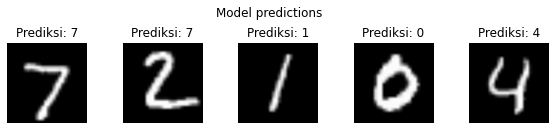

In [128]:
img_ts = np.array([prepare_image(img, IMAGE_SHAPE) for img in img_test[:5]])

predicted = model.predict(img_ts)
pred_label = np.argmax(predicted, axis=-1)
show_figures(img_ts, pred_label)

### 2.2. Model Subclassing

Selain dengan sequential atau functional, membuat model bisa lebih leluasa dengan membuat subclass langsung dari Model Keras.

Membuat struktur dari sebuah subclass dari model mirip dengan bagaimana membangun subclass dari layer, yakni sebagai berikut
```
class NamaModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        # inisiasi atribut

    def call(self, inputs):
        # aktivitas yang dilakukan pada input di dalam model
        return output
```

Kali ini kita akan mencoba membangun sebuah miniatur dari model Residual Network (ResNet). Miniatur ini kurang lebih akan berbentuk seperti ini

![](https://github.com/phoenixfin/deeplearning-notebooks/blob/main/dummy_resnet.png?raw=true)

Dalam Identity Block, terdapat *skip connection* (disebut juga residual) yang menghubungkan ujung ke ujung untuk mempertahankan keutuhan informasi yang dipropagasikan. 

In [129]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

Kita definiskan sekarang model ResNet yang lengkapnya.

In [130]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.reshaper = tf.keras.layers.Reshape((28,28,1))
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.reshaper(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

In [131]:
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet.fit(img_train, lab_train, epochs=1)

1500/1500 [==============================] - 188s 125ms/step - loss: 0.3203 - accuracy: 0.9166


Cara membuat model bisa campuran sequential, functional, maupun subclassing. Sebagai contoh, membangun ResNet di atas bisa juga dituliskan seperti ini

In [ ]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
            tf.keras.layers.BatchNormalization()
            tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
            tf.keras.layers.BatchNormalization()
            tf.keras.layers.Activation('relu')                            
        ])
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.seq(input_tensor)
        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

resnet = tf.keras.Sequential([
    tf.keras.layers.Reshape((28,28,1))
    tf.keras.layers.Conv2D(64, 7, padding='same')
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.Activation('relu')
    tf.keras.layers.MaxPool2D((3, 3))
    IdentityBlock(64, 3)
    IdentityBlock(64, 3)
    tf.keras.layers.GlobalAveragePooling2D()
    tf.keras.layers.Dense(10, activation='softmax')                                        
])

## 3. Low Level API

### 3.1. Tensor

#### 3.1.1. Tensor Konstan

Tensor konstan merupakan tensor biasa seperti halnya array yang nilainya bisa dimanipulasi. Berikut beberapa terminologi yang dipakai (agak berbeda dari terminologi matematis):
- *Axis* / *Dimension*: Suatu "basis" dari tensor tersebut 
- *Shape*: Tuple yang berisi banyaknya elemen dari setiap basis
- *Rank*: Panjang dari *shape*, atau banyaknya basis
- *Size*: Total banyaknya elemen di tensor

Contoh, misal kita miliki tensor $x$ berbentuk matriks $2\times 2$. Maka, $x$ memiliki rank-2 dengan bentuk atau *shape* (2, 2), dengan *axis* pertama sebagai baris dan *axis* kedua sebagai kolom, serta secara total berukuran 4.  

In [ ]:
rank_0_tensor = tf.constant(4)
rank_1_tensor = tf.constant([2.0, 3.0, 4.0])
rank_2_tensor = tf.constant([[1, 2],
                             [3, 4],
                             [5, 6]], dtype=tf.float16)
rank_3_tensor = tf.constant([[[ 0,  1,  2,  3,  4],
                              [ 5,  6,  7,  8,  9]],
                             [[10, 11, 12, 13, 14],
                              [15, 16, 17, 18, 19]],
                             [[20, 21, 22, 23, 24],
                              [25, 26, 27, 28, 29]],])

print("Rank 0:", rank_0_tensor)
print("\nRank 1:", rank_1_tensor)
print("\nRank 2:", rank_2_tensor)
print("\nRank 3:", rank_3_tensor)

Mengubah tensor menjadi array bisa dilakukan 2 cara:


In [ ]:
np.array(rank_2_tensor)
rank_2_tensor.numpy()

Kita juga bisa membangun otomatis suatu tensor bentuk umum atau secara acak

In [ ]:
random_ts1 = tf.random.normal((2,2), mean=0, stddev=1)
random_ts2 = tf.random.uniform((2,2), minval=0, maxval=2)

ones = tf.ones((2,2))
zeros = tf.zeros((2,2))
id = tf.eye(2)

print("Tensor of Ones:", ones,"\n")
print("Tensor of Zeros:", zeros,"\n")
print("Identity Tensor:", id,"\n")
print("Normal random tensor:", random_ts1,"\n")
print("Uniform random tensor:", random_ts2)

Kita juga bisa memanipulasi bentuk dari tensor yang sudah ada dengan beragam operasi

In [ ]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
print("=== Kita bisa terapkan padding:\n")
paddings = tf.constant([[1, 1,], [2, 2]])
print("Padding constant:", tf.pad(t, paddings, "CONSTANT"),"\n")
print("Padding reflect:", tf.pad(t, paddings, "REFLECT"),"\n")
print("Padding symmetric:", tf.pad(t, paddings, "SYMMETRIC"),"\n")

print("=== Dimensinya bisa ditambah:\n")
print("Tambah dimensi di axis pertama:", tf.expand_dims(t, 0),"\n")
print("Tambah dimensi di axis kedua:",tf.expand_dims(t, 1),"\n")
print("Tambah dimensi di axis ketiga:",tf.expand_dims(t, 2),"\n")

print("=== Bisa di-reshape juga:","\n")
print(tf.reshape(t, (6,)),"\n")
print(tf.reshape(t, (3,2)),"\n")

Kita bisa bikin tensor dari beragam tipe data yang lain

In [ ]:
lst = [1,2,3,4]
tupl = (1,2,3,4)
arr = np.array([1,2,3,4])
srs = pd.Series([1,2,3,4])
df = pd.DataFrame({'a':[1,2,3,4],'b':[5,6,7,8]})

lst_ts = tf.convert_to_tensor(lst)
tupl_ts = tf.convert_to_tensor(tupl)
arr_ts = tf.convert_to_tensor(arr)
srs_ts = tf.convert_to_tensor(srs)
df_ts = tf.convert_to_tensor(df)

print("Dari List:", lst_ts)
print("Dari Tuple:", tupl_ts)
print("Dari Array:", arr_ts)
print("Dari Series:", srs_ts)
print("Dari DataFrame:", df_ts)
print("Dari List:", lst_ts)

#### 3.1.2. Operasi Matematika

Kita bisa jalankan operasi aritmatika dasar dengan 2 cara:
- Dengan metode dari TF, seperti `tf.add` atau `tf.multiply`, atau
- Dengan *operator overloading*, seperti `+`, `*`, atau `@`.

In [ ]:
a = tf.constant([[1, 2],
                 [3, 4]])
b = tf.constant([[1, 1],
                 [1, 1]]) 

print("--- Penjumlahan ---")
print(tf.add(a, b), "\n")
print(a + b, "\n") 

print("--- Perkalian per elemen ---")
print(tf.multiply(a, b), "\n")
print(a * b, "\n") 

print("--- Perkalian matriks ---")
print(tf.matmul(a, b), "\n")
print(a @ b, "\n") 

Berbagai fungsi matematis juga tersedia

In [ ]:
c = tf.constant([[4.5, 5.3], [10.1, -1.0]])

print("Original: ", c)
print("\nRound:", tf.round(c))
print("\nAbsolute:", tf.abs(c))
print("\nMaximum:", tf.reduce_max(c))
print("\nMaximum Index:", tf.argmax(c))

print("\nExponent:", tf.exp(c))
print("\nPower of 2:", tf.pow(c,2))
print("\nSquare Root:", tf.sqrt(c))
print("\nSine:", tf.sin(c))

print("\nCumulative Sum:", tf.cumsum(c))
print("\nReduced Sum:", tf.reduce_sum(c))
print("\nMean:", tf.reduce_mean(c))
print("\nStandard Deviation:", tf.math.reduce_std(c))

print("\nSigmoid:", tf.nn.sigmoid(c))
print("\nSoftmax:", tf.nn.softmax(c))
print("\nRelu:", tf.nn.relu(c))

Bisa juga bermain bilangan kompleks dengant tensor

In [ ]:
d = tf.complex(1., 2.)

print(d)
print("Real part:",tf.math.real(d))
print("Imagninary part:",tf.math.imag(d))
print("Args:",tf.math.angle(d))
print("Absolute:", tf.math.abs(d))

Library khusus aljabar linier juga ada.

In [ ]:
e = tf.constant([[1.,2.], [3.,4.]])
print(e)

eigval, eigvec = tf.linalg.eig(e)
inverse = tf.linalg.inv(e)
Sig, U, V = tf.linalg.svd(e)
adj = tf.linalg.adjoint(e)
det = tf.linalg.det(e)
diag = tf.linalg.diag_part(e)

print("\nNilai Eigen:", eigval)
print("\nVector Eigen:", eigvec)
print("\nNilai Singular:", Sig)
print("\nAdjoint:", adj)
print("\nDeterminan:", det)
print("\nKomponen Diagonal:", diag)


#### 3.1.3. Bentuk Lain

Tensor di TF juga punya tensor bentuk lain seperti:
- Ragged Tensor, tensor yang jumlah elemen di salah satu dimensinya tidak menentu atau berbeda-beda.
- Sparse Tensor, tensor yang isinya sebagian besar 0 kecuali di beberapa posisi.

In [ ]:
ragged_list = [
    [0, 1, 2, 3],
    [4, 5],
    [6, 7, 8],
    [9]]
    
tensor = tf.constant(ragged_list)

In [ ]:
ragged_tensor = tf.ragged.constant(ragged_list)
print(ragged_tensor)
print(ragged_tensor.shape)

In [ ]:
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]],
                                       values=[1, 2],
                                       dense_shape=[3, 4])
print(sparse_tensor, "\n")
print(tf.sparse.to_dense(sparse_tensor))

### 3.2. Dataset API

Dataset API merupakan framework pengelolaan dataset yang dibuat oleh tensorflow di bawah modul `tf.data`. Berikut akan diperlihatkan bagaimana API ini bekerja.

#### 3.2.1. Data Pipeline

Salah satu fungsi dari API ini adalah kemudahan dalam pembuatan data pipeline, sehingga dari data mentah sampai masuk ke model, itu semua bisa di-handle dengan lebih kompak. Kasus penggunaannya cukup banyak, untuk kali ini akan didemonstrasikan penggunaannya pada pembuatan data *time series*.

Mula-mula, misalkan kita punya data *time series* yang digenerate dari 1 sampai 100. Membuat Dataset-nya cukup dengan metode `from_tensor_slices` dari modul `tf.data.Dataset`.

In [ ]:
series = np.arange(100)

dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

Perhatikan bahwa hasil dataset yang dibuat sudah berupa bundel objek dari kelas `TensorSliceDataset`. Untuk melihat isinya, gunakan metode `take`, dengan argumen banyaknya data yang mau diambil.

In [ ]:
for data in dataset.take(10):
    print(data)

Dapat kita lihat bahwa setiap komponen data-nya sekarang sudah otomatis menjadi Tensor. Selanjutnya, kita akan membuat *window*, yakni suatu rentang data yang akan dianggap sebagai satu set input. 

In [ ]:
dataset = dataset.window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(4))

for data in dataset.take(10):
    print(data.numpy())

Sekarang, kita sudah miliki data yang berisi kumpulan *window* berisi 4 nilai. Data ini kemudian kita acak untuk menghilangkan bias

In [ ]:
dataset = dataset.shuffle(1000)
for data in dataset.take(10):
    print(data.numpy())

Kita kemudian akan membuat label (target) dari setiap data ini. Dalam suatu model *time series*, bila diberi input suatu rentang data berurutan, maka kita ingin modelnya bisa memprediksi nilai di waktu berikutnya. Maka dari itu, kita ambil nilai terakhir dari setiap *window* sebagai labelnya. Kita gunakan metode `map` yang akan memroses setiap data satu per satu melalui fungsi yang dimasukkan sebagai argumen.

In [ ]:
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
for data, label in dataset.take(10):
    print(data.numpy(),'->', label.numpy())

Kita kemudian kelompokkan lagi data-data ini menjadi batch berisi 10 window.

In [ ]:
dataset = dataset.batch(10)
for data, label in dataset.take(2):
    print(data.numpy(),'->', label.numpy())

Secara keseluruhan, pipeline yang kita buat akan seperti ini

In [ ]:
# Secara keseluruhan  jadi seperti ini
ds = tf.data.Dataset.from_tensor_slices(series)
ds = ds.window(4, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda window: window.batch(4))
ds = ds.shuffle(1000)
ds = ds.map(lambda window: (window[:-1], window[-1]))
ds = ds.batch(10)
ds = ds.prefetech(1) # ini tambahan untuk meningkatkan performa

Variabel `ds` ini dapat langsung dimasukkan ke `model.fit`. 

#### 3.2.2. TF Datasets

Tensorflow memiliki satu library terpisah untuk mengelola kumpulan datasets, yakni tensorflow-datasets atau tfds. TFDS memiliki puluhan dataset berbagai bentuk yang siap panggil, dari audio, gambar, sampai teks. Data yang diambil dari TFDS akan langsung berbentuk objek `Datasets` yang dengan mudah kita atur pipelinenya.

Kali ini kita akan muat ulang data digit mnist dengan tfds.

In [ ]:
mnist = tfds.load('mnist', split=['train[:80%]','train[80%:]','test'], shuffle_files=True, as_supervised=True)
mnist

Perhatikan bahwa splitting data dapat dengan mudah dilakukan, dan langsung menghasikan 3 data untuk training-validation-test. Selanjutnya kita siapkan pipelinenya.

In [ ]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

def create_pipeline(ds, is_shuffle):
    ds = ds.map(normalize_img)
    ds = ds.cache()
    if is_shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(128)
    ds = ds.prefetch(1)
    return ds

ds_train = create_pipeline(mnist[0], True)
ds_val = create_pipeline(mnis[1], True)
ds_test = create_pipeline(mnist[2], False)

Kita pun bisa langsung masukkan ke model.

In [ ]:
model = build_model()
model.fit(ds_train, epochs=2, validation_data=ds_val)
model.evaluate(ds_test)

### 3.3. Custom Training Process

Proses training di TF bisa didefinisikan secara manual dari awal sampai akhir, tanpa menggunakan metode `fit`. Mula-mula kita definisikan dulu modelnya dengan functional API.

In [ ]:
inputs = tf.keras.Input(shape=(28,28), name="digits")
flat = tf.keras.layers.Flatten()(inputs)
x1 = tf.keras.layers.Dense(64, activation="relu")(flat)
x2 = tf.keras.layers.Dense(64, activation="relu")(x1)
outputs = tf.keras.layers.Dense(10, name="predictions")(x2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

Selanjutnya, didefinisikan juga optimizer, fungsi loss, dan metric yang digunakan. 

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

Kita di sini mengubah data gambar yang ada sebelumnya menjadi TF Datasets dengan pipeline yang sesuai.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((img_train, lab_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

val_ds = tf.data.Dataset.from_tensor_slices((img_val, lab_val))
val_ds = val_ds.batch(batch_size)

Saatnya melakukan proses training manual! Perhatikan  langkahnya baik-baik

In [ ]:
# tetapkan jumlah epochs
epochs = 3

# iterasi setiap epoch
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # iterasi setiap batch di training Datasets
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        # tetapkan scope Gradient Tape untuk merekam proses perhitungan loss
        with tf.GradientTape() as tape:
            # hitung output dari model
            y_out = model(x_batch_train, training=True)
            # hitung loss dari output yang dihasilkan
            loss_value = loss_fn(y_batch_train, y_out)
        # hitung gradient dari perhitungan yang sudah direkam 
        # terhadap parameter-parameter di dalam modelnya model
        grads = tape.gradient(loss_value, model.trainable_weights)
        # minta optimizer untuk update parameter 
        # berdasarkan gradient yang sudah dihitung
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # update metric untuk batch ini
        train_acc_metric.update_state(y_batch_train, y_out)
        if step % 200 == 0:
            print(step, "steps: ", loss_value.numpy())
    # dapatkan akumulasi metric di epoch ini
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    train_acc_metric.reset_states()

    # lakukan hal yang serupa pada validation Datasets
    # perbedaannya hanya kali ini tidak dilakukan update parameter
    for x_batch_val, y_batch_val in val_ds:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))

**That is all!**
Tentu saja masih banyak hal di Tensorflow yang belum kebahas di sini, tapi semoga ini bisa jadi awal perjalanan deep learnjng anda ke depan!

> Aditya Firman Ihsan

![](https://i.pinimg.com/236x/57/88/60/57886048a910db370c961afab837cca1--happy-new-year-atlanta.jpg)